In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
Images_Tumor_path = "/content/drive/MyDrive/CSAW_Images_processed/Tumor"
Images_Tumor_Folder = os.listdir(Images_Tumor_path)

Masks_Tumor_path = "/content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations"
Masks_Tumor_Folder = os.listdir(Masks_Tumor_path)

Images_Healthy_path = "/content/drive/MyDrive/CSAW_Images_processed/Healthy"
Images_Healthy_Folder = os.listdir(Images_Healthy_path)

Masks_Healthy_path = "/content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations"
Masks_Healthy_Folder = os.listdir(Masks_Healthy_path)

Mounted at /content/drive


In [2]:
import os
# List all files in tumor folder (excluding the annotations subfolder)
tumor_images = [
    f for f in os.listdir(Images_Tumor_path)
    if os.path.isfile(os.path.join(Images_Tumor_path, f))
]

# List all files in healthy folder (excluding the annotations subfolder)
healthy_images = [
    f for f in os.listdir(Images_Healthy_path)
    if os.path.isfile(os.path.join(Images_Healthy_path, f))
]

print(f"Total tumor DICOM images: {len(tumor_images)}")
print(f"Total healthy DICOM images: {len(healthy_images)}")


Total tumor DICOM images: 743
Total healthy DICOM images: 743


# **Imports**

In [2]:
import os
import shutil

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import label

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    jaccard_score, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import albumentations as A

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# List all files in tumor folder (excluding the annotations subfolder)
tumor_images = [
    f for f in os.listdir(Images_Tumor_path)
    if os.path.isfile(os.path.join(Images_Tumor_path, f))
]

# List all files in healthy folder (excluding the annotations subfolder)
healthy_images = [
    f for f in os.listdir(Images_Healthy_path)
    if os.path.isfile(os.path.join(Images_Healthy_path, f))
]

print(f"Total tumor DICOM images: {len(tumor_images)}")
print(f"Total healthy DICOM images: {len(healthy_images)}")


Total tumor DICOM images: 743
Total healthy DICOM images: 743


# **Functions**

In [4]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Weighted Cross-Entropy Loss
def weighted_binary_crossentropy(y_true, y_pred, pos_weight=3.0, neg_weight=1.0):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    y_true = tf.cast(y_true, tf.float32)
    loss = -(
        pos_weight * y_true * tf.math.log(y_pred) +
        neg_weight * (1 - y_true) * tf.math.log(1 - y_pred)
    )
    return tf.reduce_mean(loss)

# Combined Loss Function
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + weighted_binary_crossentropy(y_true, y_pred)

In [5]:
# ROC Curve
def evaluate_roc_auc(model, X_test, y_test):

    # Predict probabilities
    y_pred = model.predict(X_test)

    # Flatten predictions and ground truth
    y_pred_flat = y_pred.flatten()
    y_true_flat = y_test.flatten()

    # Compute AUC
    auc_score = roc_auc_score(y_true_flat, y_pred_flat)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)

    # Plot
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc_score

In [6]:
# Pixel-level evaluation Metrics
def evaluate_segmentation_model_metrics(model, X_test, y_test, threshold=0.5):

    # Predict probabilities
    y_pred = model.predict(X_test)

    # Squeeze if needed
    if y_pred.shape[-1] == 1:
        y_pred = y_pred.squeeze(-1)
    if y_test.shape[-1] == 1:
        y_test = y_test.squeeze(-1)

    # Flatten
    y_true_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()
    y_pred_bin = (y_pred_flat >= threshold).astype(np.uint8)

    # Metrics
    iou = jaccard_score(y_true_flat, y_pred_bin)
    dice = 2 * np.sum(y_pred_bin * y_true_flat) / (np.sum(y_pred_bin) + np.sum(y_true_flat) + 1e-7)
    accuracy = accuracy_score(y_true_flat, y_pred_bin)
    precision = precision_score(y_true_flat, y_pred_bin, zero_division=0)
    recall = recall_score(y_true_flat, y_pred_bin, zero_division=0)
    roc_auc = roc_auc_score(y_true_flat, y_pred_flat)

    metrics = {
        "IoU": [iou],
        "Dice": [dice],
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "ROC AUC": [roc_auc]
    }

    df = pd.DataFrame(metrics)


    return df

In [7]:
# Extract bounding box
def bbox_from_mask(mask):
    mask = mask.squeeze()
    components, num_features = label(mask)
    bboxes = []
    for i in range(1, num_features + 1):
        rows, cols = np.where(components == i)
        x_min, x_max = cols.min(), cols.max()
        y_min, y_max = rows.min(), rows.max()
        bboxes.append([x_min, y_min, x_max, y_max])
    return bboxes

# Bounding box Dice
def bbox_dice_score(bboxes_pred, bboxes_true):
  # If prediction and GT have no bounding box (= the case is healthy) Dice will be 1
    if not bboxes_pred and not bboxes_true:
        return 1.0
    dices = []
    for pred in bboxes_pred:
        best_dice = 0.0
        for true in bboxes_true:
            x_left = max(pred[0], true[0])
            y_top = max(pred[1], true[1])
            x_right = min(pred[2], true[2])
            y_bottom = min(pred[3], true[3])

            if x_right < x_left or y_bottom < y_top:
                continue

            intersection = (x_right - x_left) * (y_bottom - y_top)
            area_pred = (pred[2] - pred[0]) * (pred[3] - pred[1])
            area_true = (true[2] - true[0]) * (true[3] - true[1])
            dice = 2 * intersection / (area_pred + area_true)
            best_dice = max(best_dice, dice)
        dices.append(best_dice)
    return np.mean(dices) if dices else 0.0

# Bounding box IoU
def bbox_iou_score(bboxes_pred, bboxes_true):
  # If prediction and GT have no bounding box (= the case is healthy) IoU will be 1
    if not bboxes_pred and not bboxes_true:
        return 1.0
    ious = []
    for pred in bboxes_pred:
        best_iou = 0.0
        for true in bboxes_true:
            x_left = max(pred[0], true[0])
            y_top = max(pred[1], true[1])
            x_right = min(pred[2], true[2])
            y_bottom = min(pred[3], true[3])

            if x_right < x_left or y_bottom < y_top:
                continue

            intersection = (x_right - x_left) * (y_bottom - y_top)
            area_pred = (pred[2] - pred[0]) * (pred[3] - pred[1])
            area_true = (true[2] - true[0]) * (true[3] - true[1])
            union = area_pred + area_true - intersection
            iou = intersection / union
            best_iou = max(best_iou, iou)
        ious.append(best_iou)
    return np.mean(ious) if ious else 0.0

In [8]:
# Bounding box-level evaluation metrics
def evaluate_bboxes_metrics(model, X_test, y_test, threshold=0.5):
    y_pred = model.predict(X_test)
    y_pred = (y_pred.squeeze() > threshold).astype(np.uint8)

    all_iou_scores = []
    all_dice_scores = []
    precisions = []
    recalls = []

    for true_mask, pred_mask in zip(y_test, y_pred):
        true_bboxes = bbox_from_mask(true_mask)
        pred_bboxes = bbox_from_mask(pred_mask)

        if not true_bboxes and not pred_bboxes:
            all_iou_scores.append(1)
            all_dice_scores.append(1)
            precisions.append(1)
            recalls.append(1)
        elif not true_bboxes or not pred_bboxes:
            all_iou_scores.append(0)
            all_dice_scores.append(0)
            precisions.append(0 if pred_bboxes else 1)
            recalls.append(0 if true_bboxes else 1)
        else:
            iou = bbox_iou_score(pred_bboxes, true_bboxes)
            dice = bbox_dice_score(pred_bboxes, true_bboxes)

            all_iou_scores.append(iou)
            all_dice_scores.append(dice)

            if iou > 0.5:
                precisions.append(1)
                recalls.append(1)
            else:
                precisions.append(0)
                recalls.append(0)

    average_iou = np.mean(all_iou_scores)
    average_dice = np.mean(all_dice_scores)
    precision = np.mean(precisions)
    recall = np.mean(recalls)

    metrics = {
        "Average IoU": [average_iou],
        "Average Dice": [average_dice],
        "Precision": [precision],
        "Recall": [recall]
    }

    return pd.DataFrame(metrics)


In [ ]:
# Row-Normalized confusion matrix for image-level evaluation
def plot_confusion_matrix_image_level(model, X_test, y_test, threshold=0.5):

    # Predict
    y_pred = model.predict(X_test, verbose=0)

    # If model output has multiple channels, take the relevant one
    if y_pred.shape[-1] > 1:
        y_pred = y_pred[..., 0]

    # Binarize predictions
    y_pred_bin = (y_pred >= threshold).astype(int)

    # For each image, check if there is any pixel > 0 (tumor)
    y_pred_image_level = np.any(y_pred_bin, axis=(1, 2))
    y_true_image_level = np.any(y_test >= 0.5, axis=(1, 2))

    # Calculate row-normalized confusion matrix
    cm = confusion_matrix(y_true_image_level, y_pred_image_level, labels=[0, 1], normalize='true')

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm * 100, display_labels=["No Tumor", "Tumor"])
    disp.plot(ax=ax, cmap='Blues', values_format=".2f")
    plt.title('Image-Level Confusion Matrix (%)')
    plt.show()


In [9]:
# Plot random patches from the dataset
def plot_random_patches(images, masks, n=5, figsize=(12, 3)):

    indices = np.random.choice(len(images), n, replace=False)

    plt.figure(figsize=(figsize[0], figsize[1] * n))

    for i, idx in enumerate(indices):
        img = images[idx]
        mask = masks[idx]

        # Scale to be 0,1
        img_display = img / 255
        mask_display = mask.squeeze()

        # 1. Image
        plt.subplot(n, 3, 3 * i + 1)
        plt.imshow(img_display)
        plt.title(f"Patch {idx} - Image")
        plt.axis("off")

        # 2. Ground Truth
        plt.subplot(n, 3, 3 * i + 2)
        plt.imshow(mask_display, cmap='gray')
        plt.title(f"Patch {idx} - Mask")
        plt.axis("off")

        # 3. Overlay
        plt.subplot(n, 3, 3 * i + 3)
        plt.imshow(img_display)
        plt.imshow(mask_display, cmap='jet', alpha=0.5)
        plt.title("Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [10]:
# Plot multiple patch segmentation predictions
def plot_multiple_segmentations(X_test, y_test, num_images, model):

    # Check if num_images is valid
    if num_images > X_test.shape[0]:
        num_images = X_test.shape[0]

    # Plot each image, true mask, and predicted mask
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 3 * num_images))

    for i in range(num_images):
        image_to_predict = X_test[i]
        true_mask = y_test[i]

        # Add batch dimension for prediction
        image_to_predict = np.expand_dims(image_to_predict, axis=0).astype(np.uint8)

        # Predict the mask for the image
        predicted_mask = model.predict(image_to_predict)
        predicted_mask = predicted_mask.squeeze()  # Remove batch dimension
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

        # Plot the images
        # 1. Original image
        axes[i, 0].imshow(image_to_predict.squeeze())
        axes[i, 0].set_title(f"Original Image {i + 1}")
        axes[i, 0].axis('off')

        # 2. Ground Truth
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title(f"True Mask {i + 1}")
        axes[i, 1].axis('off')

        # 3. Prediction
        axes[i, 2].imshow(predicted_mask, cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask {i + 1}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
# Plot patches with GT, Prediction with Bounding Boxes, Dice and IoU for pixel and Bounding Boxes, and Overlay
def evaluate_and_plot_bboxes_patch_subplots(X_test, y_test, model, num_images, edgecolor_model, threshold=0.5):
    if num_images > len(X_test):
        num_images = len(X_test)

    indices = np.random.choice(len(X_test), num_images, replace=False)
    fig, axes = plt.subplots(num_images, 4, figsize=(16, 4 * num_images))

    for idx, i in enumerate(indices):
        image = X_test[i]
        true_mask = y_test[i]

        # Ensure uint8 for visualization
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        image_input = np.expand_dims(image, axis=0)
        pred_mask = model.predict(image_input, verbose=0).squeeze()
        pred_bin = (pred_mask > threshold).astype(np.uint8)

        # Ensure true mask is binary and same dtype
        true_bin = (true_mask.squeeze() > 0.5).astype(np.uint8)
        pred_bin = pred_bin.astype(np.uint8)

        # Pixel Dice & IoU
        # If image is healthy in GT and Prediction Dice and IoU are 1
        if np.sum(true_bin) == 0 and np.sum(pred_bin) == 0:
            pixel_dice = 1.0
            pixel_iou = 1.0
        else:
            intersection = np.sum(true_bin * pred_bin)
            pixel_dice = (2. * intersection) / (np.sum(pred_bin) + np.sum(true_bin) + 1e-7)
            pixel_iou = intersection / (np.sum(pred_bin) + np.sum(true_bin) - intersection + 1e-7)

        # Bounding boxes
        true_bboxes = bbox_from_mask(true_mask.squeeze())
        pred_bboxes = bbox_from_mask(pred_bin)

        bbox_dice = bbox_dice_score(pred_bboxes, true_bboxes)
        bbox_iou = bbox_iou_score(pred_bboxes, true_bboxes)

        # Subplots
        ax_orig = axes[idx, 0]
        ax_true = axes[idx, 1]
        ax_pred = axes[idx, 2]
        ax_overlay = axes[idx, 3]

        # 1. Original Image
        ax_orig.imshow(image.squeeze(), cmap='gray')
        ax_orig.set_title("Original Image")
        ax_orig.axis('off')

        # 2. Ground Truth
        ax_true.imshow(true_mask.squeeze(), cmap='gray')
        ax_true.set_title("Ground Truth")
        for bbox in true_bboxes:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 fill=False, edgecolor='green', linewidth=2)
            ax_true.add_patch(rect)
        ax_true.axis('off')

        # 3. Predicted Mask + metrics
        ax_pred.imshow(pred_bin, cmap='gray')
        ax_pred.set_title(f"Predicted Mask\n"
                          f"Pixel Dice: {pixel_dice:.3f}, IoU: {pixel_iou:.3f}\n"
                          f"BBox Dice: {bbox_dice:.3f}, IoU: {bbox_iou:.3f}")
        for bbox in pred_bboxes:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 fill=False, edgecolor=edgecolor_model, linewidth=2)
            ax_pred.add_patch(rect)
        ax_pred.axis('off')

        # 4. Overlay
        ax_overlay.imshow(image.squeeze(), cmap='gray')
        ax_overlay.set_title("Overlay BBoxes")
        for bbox in true_bboxes:
            rect_true = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                      fill=False, edgecolor='green', linewidth=1.5)
            ax_overlay.add_patch(rect_true)
        for bbox in pred_bboxes:
            rect_pred = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                      fill=False, edgecolor=edgecolor_model, linewidth=1.5)
            ax_overlay.add_patch(rect_pred)
        ax_overlay.axis('off')

    plt.tight_layout()
    plt.show()


In [12]:
# Generate prediction for full images in patches with a sliding window
def predict_full_mask_from_patches(model, image, patch_size=(128, 128), stride=64, padding=32):

    # Get image dimension
    ndim = image.ndim
    # Pad image to avoid edge artifacts
    if ndim == 2:
        image_padded = np.pad(image, ((padding, padding), (padding, padding)), mode='reflect')
    elif ndim == 3:
        image_padded = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='reflect')
    else:
        raise ValueError("Image must be 2D or 3D.")

    # Get dimensions of padded imahe
    H_pad, W_pad = image_padded.shape[:2]
    # Initialize arrays for prediction and weight map
    full_mask = np.zeros((H_pad, W_pad), dtype=np.float32)
    weight_map = np.zeros((H_pad, W_pad), dtype=np.float32)

    # Slide window accross the image and perform predictions
    for y in range(0, H_pad - patch_size[0] + 1, stride):
        for x in range(0, H_pad - patch_size[1] + 1, stride):

            # Extract patch
            patch = image_padded[y:y+patch_size[0], x:x+patch_size[1]]

            # Prepare patch input for model
            patch_input = np.expand_dims(patch, axis=0).astype(np.float32)

            #If patch is grayscale, convert it to 3-channel by repeating (needed for predictioN)
            if patch_input.shape[-1] != 3:
                patch_input = np.repeat(patch_input[..., np.newaxis], 3, axis=-1)

            # Predict mask for patch
            pred = model.predict(patch_input, verbose=0)[0, :, :, 0]

            # Accumulate prediction values and weight counts
            full_mask[y:y+patch_size[0], x:x+patch_size[1]] += pred
            weight_map[y:y+patch_size[0], x:x+patch_size[1]] += 1.0

    #Avoid division by zero
    weight_map[weight_map == 0] = 1.0

    # Average overlapping predictions
    averaged_mask = full_mask / weight_map

    # Remove padding and return final mask
    return averaged_mask[padding:-padding, padding:-padding]

# Plot original image, GT and Prediction mask with Bounding Box, Dice, IoU for pixel and bounding box, image with bounding box overlay, and heatmap
def plot_patchwise_predictions(model, X, y, n, patch_size=(128, 128), stride=64, threshold=0.5, padding=32):
    if n > len(X):
        n = len(X)

    # Randomly select indices to visualize
    indices = np.random.choice(len(X), n, replace=False)
    fig, axes = plt.subplots(n, 5, figsize=(20, 4 * n))  # 5 columns

    for i, idx in enumerate(indices):
        image = X[idx]
        true_mask = y[idx]

        # Predict full image mask using patch-based sliding window
        pred_mask = predict_full_mask_from_patches(model, image, patch_size, stride, padding=padding)

        # Binarize predicted mask
        pred_bin = (pred_mask > threshold).astype(np.uint8)

        # Pixel-level Dice & IoU
        if np.sum(true_mask) == 0 and np.sum(pred_bin) == 0:
            pixel_dice = 1.0
            pixel_iou = 1.0
        else:
            intersection = np.sum(pred_bin * true_mask)
            union = np.sum(pred_bin) + np.sum(true_mask) - intersection
            pixel_dice = (2. * intersection) / (np.sum(pred_bin) + np.sum(true_mask) + 1e-7)
            pixel_iou = intersection / (union + 1e-7)

        # Bounding boxes
        true_bboxes = bbox_from_mask(true_mask)
        pred_bboxes = bbox_from_mask(pred_bin)

        # Bounding box-level Dice & IoU
        bbox_dice = bbox_dice_score(pred_bboxes, true_bboxes)
        bbox_iou = bbox_iou_score(pred_bboxes, true_bboxes)

        # Subplots
        ax_orig = axes[i, 0] if n > 1 else axes[0]
        ax_true = axes[i, 1] if n > 1 else axes[1]
        ax_pred = axes[i, 2] if n > 1 else axes[2]
        ax_overlay = axes[i, 3] if n > 1 else axes[3]
        ax_heat = axes[i, 4] if n > 1 else axes[4]

        # Column 1: Original Image
        image = np.clip(image.squeeze(), 0, 255).astype(np.uint8)
        ax_orig.imshow(image, cmap='gray')
        ax_orig.set_title("Original Image")
        ax_orig.axis('off')

        # Column 2: Ground Truth + BBox
        ax_true.imshow(true_mask.squeeze(), cmap='gray')
        ax_true.set_title("Ground Truth")
        for bbox in true_bboxes:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                                 fill=False, edgecolor='green', linewidth=2)
            ax_true.add_patch(rect)
        ax_true.axis('off')

        # Column 3: Predicted Mask + BBox + Metrics
        ax_pred.imshow(pred_bin, cmap='gray')
        ax_pred.set_title(f"Predicted Mask\nPixel Dice: {pixel_dice:.3f}, IoU: {pixel_iou:.3f}\n"
                          f"BBox Dice: {bbox_dice:.3f}, IoU: {bbox_iou:.3f}")
        for bbox in pred_bboxes:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                                 fill=False, edgecolor='red', linewidth=2)
            ax_pred.add_patch(rect)
        ax_pred.axis('off')

        # Column 4: Overlay (Original + BBoxes)
        ax_overlay.imshow(image.squeeze(), cmap='gray')
        ax_overlay.set_title("Overlay BBoxes")
        for bbox in true_bboxes:
            rect_true = plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                                      fill=False, edgecolor='green', linewidth=1.5)
            ax_overlay.add_patch(rect_true)
        for bbox in pred_bboxes:
            rect_pred = plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                                      fill=False, edgecolor='red', linewidth=1.5)
            ax_overlay.add_patch(rect_pred)
        ax_overlay.axis('off')

        # Column 5: Heatmap
        heatmap = ax_heat.imshow(pred_mask, cmap='viridis')
        ax_heat.set_title("Raw Prediction (Heatmap)")
        ax_heat.axis('off')
        fig.colorbar(heatmap, ax=ax_heat, shrink=0.7)

    plt.tight_layout()
    plt.show()


In [28]:
# Plot patches and predictions made by both the Baseline and the Fine-Tuned Model
def evaluate_and_plot_bboxes_two_models(X_test, y_test, model1, model2, num_images, threshold=0.5):
    if num_images > len(X_test):
        num_images = len(X_test)

    indices = np.random.choice(len(X_test), num_images, replace=False)
    fig, axes = plt.subplots(num_images, 5, figsize=(20, 4 * num_images))

    for idx, i in enumerate(indices):
        image = X_test[i]
        true_mask = y_test[i]

        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        image_input = np.expand_dims(image, axis=0)

        # Predictions
        pred1 = model1.predict(image_input, verbose=0).squeeze()
        pred2 = model2.predict(image_input, verbose=0).squeeze()
        pred1_bin = (pred1 > threshold).astype(np.uint8)
        pred2_bin = (pred2 > threshold).astype(np.uint8)

        true_bin = (true_mask.squeeze() > 0.5).astype(np.uint8)

        # Pixel metrics
        def compute_pixel_metrics(pred_bin):
            if np.sum(true_bin) == 0 and np.sum(pred_bin) == 0:
                return 1.0, 1.0
            intersection = np.sum(true_bin * pred_bin)
            dice = (2. * intersection) / (np.sum(pred_bin) + np.sum(true_bin) + 1e-7)
            iou = intersection / (np.sum(pred_bin) + np.sum(true_bin) - intersection + 1e-7)
            return dice, iou

        dice1, iou1 = compute_pixel_metrics(pred1_bin)
        dice2, iou2 = compute_pixel_metrics(pred2_bin)

        # Bounding boxes
        true_bboxes = bbox_from_mask(true_bin)
        bboxes1 = bbox_from_mask(pred1_bin)
        bboxes2 = bbox_from_mask(pred2_bin)

        bbox_dice1 = bbox_dice_score(bboxes1, true_bboxes)
        bbox_iou1 = bbox_iou_score(bboxes1, true_bboxes)

        bbox_dice2 = bbox_dice_score(bboxes2, true_bboxes)
        bbox_iou2 = bbox_iou_score(bboxes2, true_bboxes)

        # Subplots
        ax_orig = axes[idx, 0]
        ax_true = axes[idx, 1]
        ax_pred1 = axes[idx, 2]
        ax_pred2 = axes[idx, 3]
        ax_overlay = axes[idx, 4]

        # 1. Original Image
        ax_orig.imshow(image.squeeze(), cmap='gray')
        ax_orig.set_title("Original Image")
        ax_orig.axis('off')

        # 2. Ground Truth
        ax_true.imshow(true_bin, cmap='gray')
        ax_true.set_title("Ground Truth")
        for bbox in true_bboxes:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 fill=False, edgecolor='green', linewidth=2)
            ax_true.add_patch(rect)
        ax_true.axis('off')

        # 3. Model 1 Prediction
        ax_pred1.imshow(pred1_bin, cmap='gray')
        ax_pred1.set_title(f"Baseline Model\nPixel Dice: {dice1:.3f}, IoU: {iou1:.3f}\n"
                           f"BBox Dice: {bbox_dice1:.3f}, IoU: {bbox_iou1:.3f}")
        for bbox in bboxes1:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 fill=False, edgecolor='blue', linewidth=2)
            ax_pred1.add_patch(rect)
        ax_pred1.axis('off')

        # 4. Model 2 Prediction
        ax_pred2.imshow(pred2_bin, cmap='gray')
        ax_pred2.set_title(f"Fine-Tuned Model\nPixel Dice: {dice2:.3f}, IoU: {iou2:.3f}\n"
                           f"BBox Dice: {bbox_dice2:.3f}, IoU: {bbox_iou2:.3f}")
        for bbox in bboxes2:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 fill=False, edgecolor='purple', linewidth=2)
            ax_pred2.add_patch(rect)
        ax_pred2.axis('off')

        # 5. Overlay of all
        ax_overlay.imshow(image.squeeze(), cmap='gray')
        ax_overlay.set_title("Overlay: GT (Green), M1 (Blue), M2 (Purple)")
        for bbox in true_bboxes:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 fill=False, edgecolor='green', linewidth=1.5)
            ax_overlay.add_patch(rect)
        for bbox in bboxes1:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 fill=False, edgecolor='blue', linewidth=1.5)
            ax_overlay.add_patch(rect)
        for bbox in bboxes2:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 fill=False, edgecolor='purple', linewidth=1.5)
            ax_overlay.add_patch(rect)
        ax_overlay.axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
# Load image data
def load_images_from_folder(folder, binarize=False):
    images = []
    filenames = []

    for filename in sorted(os.listdir(folder)):
        full_path = os.path.join(folder, filename)
        if not os.path.isfile(full_path):
            continue
        if not filename.lower().endswith(('.png')):
            print(f"Skipping {filename}: Not a supported image format.")
            continue

        # Load image in grayscale
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping {filename}: Failed to load image.")
            continue
        if img.shape != (224, 224):
            print(f"Skipping {filename}: Unexpected shape {img.shape}")
            continue

        # If Binarize, convert image to binary mask (0 and 1), needed for mask images
        if binarize:
            img = np.where(img > 0, 1, 0).astype(np.uint8)

        images.append(img)
        filenames.append(filename)

    return np.array(images), filenames


# Extract patches that contain tumors
def extract_tumor_patches(images, masks, patch_size=(128, 128), max_patches_per_image=6):
    patch_images = []
    patch_masks = []
    H, W = patch_size

    for img, mask in zip(images, masks):
        # Get coordinates of tumor pixels
        tumor_coords = np.argwhere(mask == 1)
        if len(tumor_coords) == 0:
            continue

        # Shuffle coordinates to get random patches
        np.random.shuffle(tumor_coords)
        patches_extracted = 0

        for coord in tumor_coords:
            y, x = coord
            # Random crop around tumor
            y1 = np.clip(y - np.random.randint(0, H), 0, img.shape[0] - H)
            x1 = np.clip(x - np.random.randint(0, W), 0, img.shape[1] - W)
            y2 = y1 + H
            x2 = x1 + W

            img_patch = img[y1:y2, x1:x2]
            mask_patch = mask[y1:y2, x1:x2]

            # Only save patches that contain tumor pixels
            if np.any(mask_patch):
                patch_images.append(img_patch)
                patch_masks.append(mask_patch)
                patches_extracted += 1

            if patches_extracted >= max_patches_per_image:
                break

    return np.array(patch_images), np.array(patch_masks)

# Extract patches that are healthy
def extract_healthy_patches(images, masks, patch_size=(128, 128), max_patches_per_image=2):
    patch_images = []
    patch_masks = []
    H, W = patch_size

    for img, mask in zip(images, masks):
        patches_extracted = 0
        attempts = 0

        # Try random location until enough patches are extracted
        while patches_extracted < max_patches_per_image and attempts < 20:
            y = np.random.randint(0, img.shape[0] - H)
            x = np.random.randint(0, img.shape[1] - W)
            mask_patch_bg = mask[y:y+H, x:x+W]

            # Ensure patch is fully background (When uing healthy images this is optional)
            if np.sum(mask_patch_bg) == 0:
                img_patch_bg = img[y:y+H, x:x+W]
                patch_images.append(img_patch_bg)
                patch_masks.append(mask_patch_bg)
                patches_extracted += 1

            attempts += 1

    return np.array(patch_images), np.array(patch_masks)


# Load full dataset, extract patches, preprocess and return for training
def load_and_prepare_patch_data(patch_size=(128, 128), random_state=42):
    # Load healthy and tumor images and masks
    healthy_images, _ = load_images_from_folder(Images_Healthy_path)
    tumor_images, _ = load_images_from_folder(Images_Tumor_path)
    healthy_masks, _ = load_images_from_folder(Masks_Healthy_path, binarize=True)
    tumor_masks, _ = load_images_from_folder(Masks_Tumor_path, binarize=True)

    # Combine datasets
    all_images = np.concatenate([tumor_images, healthy_images], axis=0)
    all_masks = np.concatenate([tumor_masks, healthy_masks], axis=0)
    labels = np.array([1] * len(tumor_images) + [0] * len(healthy_images))

    # Stratified split to maintain class balance
    # Train/ Test
    X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
        all_images, labels, all_masks, test_size=0.3, stratify=labels, random_state=random_state
    )
    # Validation/ Test
    X_val, X_test, y_val, y_test, mask_val, mask_test = train_test_split(
        X_test, y_test, mask_test, test_size=0.2, stratify=y_test, random_state=random_state + 1
    )

    # Helper function to extract tumor/healthy patches based on label
    def extract_patches(images, masks, labels):
        patch_imgs = []
        patch_masks = []
        tumor_patch_count = 0
        healthy_patch_count = 0

        for img, mask, label in zip(images, masks, labels):
            if label == 1:
                patches, masks_out = extract_tumor_patches([img], [mask], patch_size)
                tumor_patch_count += len(patches)
            else:
                patches, masks_out = extract_healthy_patches([img], [mask], patch_size)
                healthy_patch_count += len(patches)

            patch_imgs.append(patches)
            patch_masks.append(masks_out)

        if patch_imgs:
            patch_imgs = np.concatenate(patch_imgs)
            patch_masks = np.concatenate(patch_masks)
        else:
            patch_imgs, patch_masks = np.array([]), np.array([])

        return patch_imgs, patch_masks, tumor_patch_count, healthy_patch_count

    # Extract patches for train/val/test
    X_train_patches, y_train_patches, train_tumor, train_healthy = extract_patches(X_train, mask_train, y_train)
    X_val_patches, y_val_patches, val_tumor, val_healthy = extract_patches(X_val, mask_val, y_val)
    X_test_patches, y_test_patches, test_tumor, test_healthy = extract_patches(X_test, mask_test, y_test)

    # Expand dims
    X_train_patches = np.expand_dims(X_train_patches, -1)
    y_train_patches = np.expand_dims(y_train_patches, -1)
    X_val_patches = np.expand_dims(X_val_patches, -1)
    y_val_patches = np.expand_dims(y_val_patches, -1)
    X_test_patches = np.expand_dims(X_test_patches, -1)
    y_test_patches = np.expand_dims(y_test_patches, -1)

    # Repeat grayscale to 3 channels (to match input requirement for CNN)
    X_train_patches = np.repeat(X_train_patches, 3, axis=-1).astype(np.float32)
    X_val_patches = np.repeat(X_val_patches, 3, axis=-1).astype(np.float32)
    X_test_patches = np.repeat(X_test_patches, 3, axis=-1).astype(np.float32)

    # Ensure mask is float32
    y_train_patches = y_train_patches.astype(np.float32)
    y_val_patches = y_val_patches.astype(np.float32)
    y_test_patches = y_test_patches.astype(np.float32)

    # Final report
    print("\nPatch Statistics:")
    print(f"  - Train set: {X_train_patches.shape[0]} patches (Tumor: {train_tumor}, Healthy: {train_healthy})")
    print(f"  - Val set:   {X_val_patches.shape[0]} patches (Tumor: {val_tumor}, Healthy: {val_healthy})")
    print(f"  - Test set:  {X_test_patches.shape[0]} patches (Tumor: {test_tumor}, Healthy: {test_healthy})")

    return X_train_patches, y_train_patches, X_val_patches, y_val_patches, X_test_patches, y_test_patches

In [14]:
# Data augmentation
def augment_data(images, masks, augmentation_factor):
    transform = A.Compose([
        A.Rotate(limit=10, p=1.0),  # ±10 degrees rotation
        A.HorizontalFlip(p=0.5),    # Left-right flip
        A.ShiftScaleRotate(
            shift_limit=0.1,       # 10% translation (left/right, up/down)
            scale_limit=0.2,       # 20% zoom in/out
            rotate_limit=0,        # No additional rotation
            p=0.9
        ),
        A.Resize(128, 128)
    ], additional_targets={'mask': 'mask'})

    images = images.astype(np.uint8)
    masks = masks.astype(np.uint8)

    # Lists to store augmented images and masks
    augmented_images = []
    augmented_masks = []

    for i in range(len(images)):
        image = images[i]
        mask = masks[i]

        # Apply multiple augmentations per image
        for _ in range(augmentation_factor):
            augmented = transform(image=image, mask=mask)
            augmented_images.append(augmented['image'])
            augmented_masks.append(augmented['mask'])

    # Convert to numpy arrays of float32
    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_masks = np.array(augmented_masks, dtype=np.float32)

    # Combine original and augmented data
    all_images = np.concatenate((images, augmented_images), axis=0)
    all_masks = np.concatenate((masks, augmented_masks), axis=0)

    # Shuffle dataset
    all_images, all_masks = shuffle(all_images, all_masks, random_state=42)

    print(f"Original images: {len(images)}, Augmented images: {len(augmented_images)}")
    print(f"Total images after augmentation: {len(all_images)}")

    return all_images, all_masks




---



Load data

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = load_and_prepare_patch_data(patch_size=(128, 128), random_state=42)


Patch Statistics:
  - Train set: 4145 patches (Tumor: 3105, Healthy: 1040)
  - Val set:   1414 patches (Tumor: 1058, Healthy: 356)
  - Test set:  360 patches (Tumor: 270, Healthy: 90)


In [16]:
# Check pixel range, and data type

print(f"X_train min: {np.min(X_train)}, max: {np.max(X_train)}, type: {X_train.dtype}")
print(f"y_train min: {np.min(y_train)}, max: {np.max(y_train)}, type: {y_train.dtype}")

X_train min: 0.0, max: 255.0, type: float32
y_train min: 0.0, max: 1.0, type: float32


**Visualize examples of the dataset**

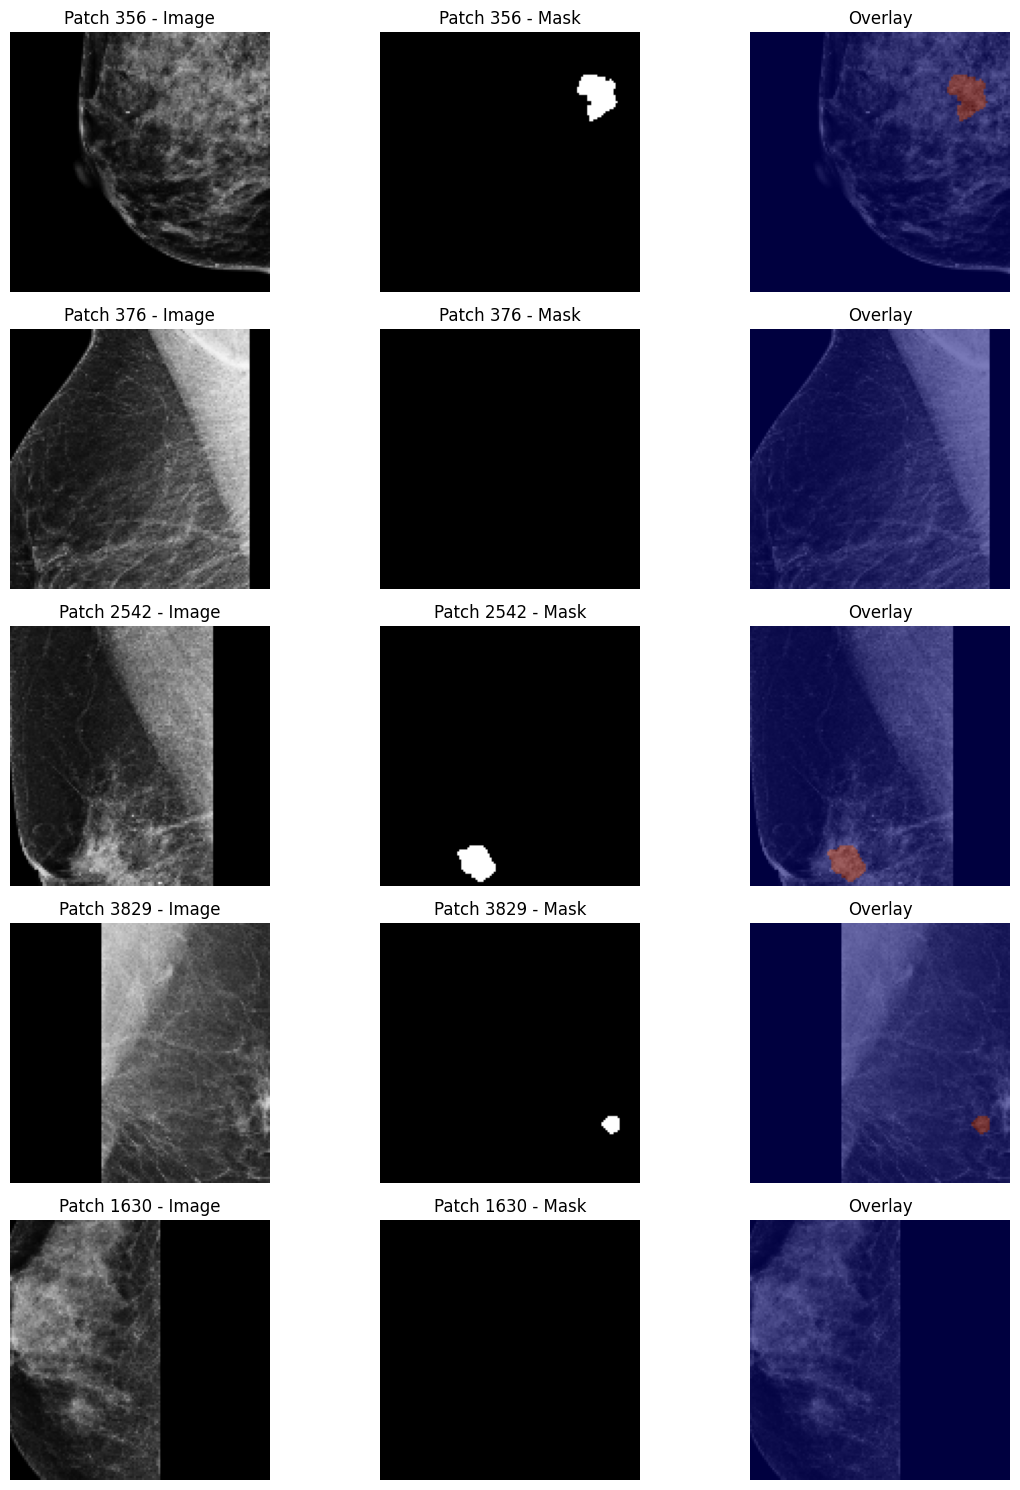

In [17]:
plot_random_patches(X_train, y_train, n=5)

**Augment training dataset**

In [ ]:
X_train_aug, y_train_aug = augment_data(X_train, y_train, augmentation_factor=2)

Original images: 4145, Augmented images: 8290
Total images after augmentation: 12435


# **U-Net model with EfficientNetB0 Encoder**

In [ ]:
# U-Net model with EfficientNet Encoder Backbone

def unet_efficientnet(fine_tune, unfreeze_layers, input_size=(128, 128, 3), dropout_rate=0.4, l2_lambda=1e-5):

    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_size)


    # Layer freezing/unfreezing, EfficientNetB0 has a total of 237 layers
    for layer in base_model.layers:
        layer.trainable = False
    if fine_tune:
        for layer in base_model.layers[-unfreeze_layers:]:
            layer.trainable = True

    # Encoder
    conv1 = base_model.get_layer('block2a_expand_activation').output
    conv2 = base_model.get_layer('block3a_expand_activation').output
    conv3 = base_model.get_layer('block4a_expand_activation').output
    conv4 = base_model.get_layer('block5a_expand_activation').output
    bottleneck = base_model.get_layer('top_activation').output

    # Decoder
    if l2_lambda and l2_lambda > 0.0:
        l2_reg = tf.keras.regularizers.l2(l2_lambda)
    else:
        l2_reg = None

    up5 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(bottleneck)
    concat5 = layers.concatenate([up5, conv4])
    conv5 = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg)(concat5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg)(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Dropout(dropout_rate)(conv5)

    up6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv5)
    concat6 = layers.concatenate([up6, conv3])
    conv6 = layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg)(concat6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg)(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Dropout(dropout_rate)(conv6)

    up7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv6)
    concat7 = layers.concatenate([up7, conv2])
    conv7 = layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg)(concat7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg)(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Dropout(dropout_rate)(conv7)

    up8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv7)
    concat8 = layers.concatenate([up8, conv1])
    conv8 = layers.Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg)(concat8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg)(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Dropout(dropout_rate)(conv8)

    # Upsampling
    up9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(conv8)
    conv9 = layers.Conv2D(8, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg)(up9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Dropout(dropout_rate)(conv9)

    # Final layer
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(conv9)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model


# **Fine-Tuned Model**
**unfreezing 25 layers**




In [ ]:
model_depth5 = unet_efficientnet(fine_tune=True, unfreeze_layers=25)
model_depth5.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 128, 128, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 6,785,444 (25.88 MB)

 Trainable params: 4,197,649 (16.01 MB)

 Non-trainable params: 2,587,795 (9.87 MB)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model
model_depth5.compile(optimizer=optimizer, loss=combined_loss, metrics=[dice_coefficient])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

early_stopping = EarlyStopping(monitor='val_dice_coefficient', patience=10, mode='max', restore_best_weights=True)

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_depth5.keras',
    monitor='val_dice_coefficient',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Fit the model
history_depth5 = model_depth5.fit(
    X_train_aug,
    y_train_aug,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=8,
    shuffle=True,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - dice_coefficient: 0.0195 - loss: 1.6946
Epoch 1: val_dice_coefficient improved from -inf to 0.02957, saving model to best_depth5.keras
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 104s 42ms/step - dice_coefficient: 0.0195 - loss: 1.6945 - val_dice_coefficient: 0.0296 - val_loss: 1.4589 - learning_rate: 1.0000e-04
Epoch 2/100
1554/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - dice_coefficient: 0.0320 - loss: 1.3740
Epoch 2: val_dice_coefficient improved from 0.02957 to 0.04797, saving model to best_depth5.keras
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - dice_coefficient: 0.0320 - loss: 1.3739 - val_dice_coefficient: 0.0480 - val_loss: 1.1748 - learning_rate: 1.0000e-04
Epoch 3/100
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - dice_coefficient: 0.0676 - loss: 1.1364
Epoch 3: val_dice_coefficient improved from 0.04797 to 0.09725, saving model to best_depth5.keras
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - dice_coefficient: 0.0676 - loss: 1.13

Training Curves

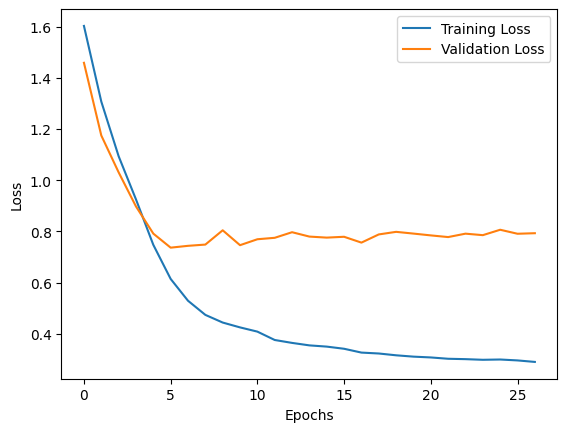

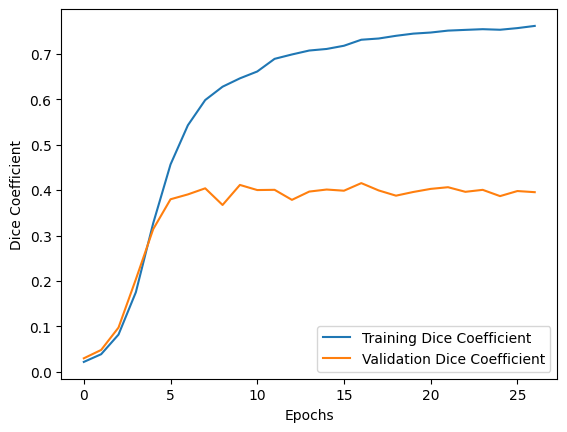

Highest Training Dice Coefficient: 0.7617
Highest Validation Dice Coefficient: 0.4154


In [ ]:
# Plot the training & validation loss values
plt.plot(history_depth5.history['loss'], label='Training Loss')
plt.plot(history_depth5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training & validation Dice Coefficient
plt.plot(history_depth5.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history_depth5.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

# Print the highest Dice coefficient values
highest_dice = max(history_depth5.history['dice_coefficient'])
highest_val_dice = max(history_depth5.history['val_dice_coefficient'])

print(f'Highest Training Dice Coefficient: {highest_dice:.4f}')
print(f'Highest Validation Dice Coefficient: {highest_val_dice:.4f}')

In [ ]:
# Saving model in drive
path_to_best_model = '/content/best_depth5.keras'

drive_path = '/content/drive/MyDrive/NewModels_AllData/tumorpatches6healthy2_Differentaugmentation/'

os.makedirs(drive_path, exist_ok=True)

shutil.copy(path_to_best_model, drive_path)
print(f'Model checkpoint saved to {drive_path}')


Model checkpoint saved to /content/drive/MyDrive/NewModels_AllData/tumorpatches6healthy2_Differentaugmentation/


In [18]:
model_path = '/content/drive/MyDrive/NewModels_AllData/tumorpatches6healthy2_Differentaugmentation/best_depth5.keras'

custom_objects = {'combined_loss': combined_loss, 'dice_coefficient': dice_coefficient}

model_fine_tuned = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

ROC Curve

12/12 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step


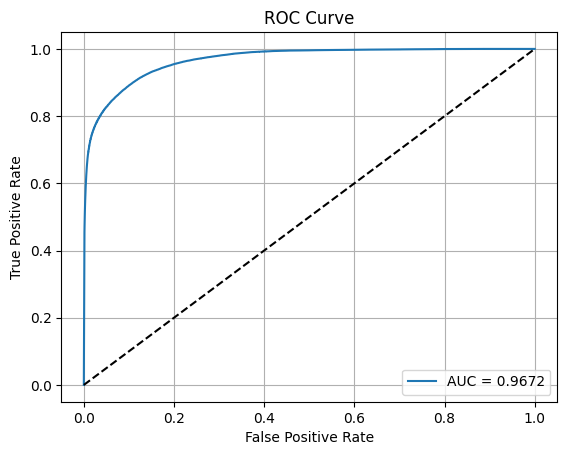

np.float64(0.9671707489242608)

In [19]:
evaluate_roc_auc(model_fine_tuned, X_test, y_test)

Pixel-Level Evaluation Metrics

In [20]:
evaluate_segmentation_model_metrics(model_fine_tuned, X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 108s 9s/step


IoU      Dice  Accuracy  Precision    Recall   ROC AUC
0  0.409078  0.580632  0.993244   0.638943  0.532075  0.967171

Bounding Box-Level Evaluation Metrics

In [21]:
evaluate_bboxes_metrics(model_fine_tuned, X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step


Average IoU  Average Dice  Precision    Recall
0     0.409572      0.461194   0.605556  0.491667

Image-Level Evaluation

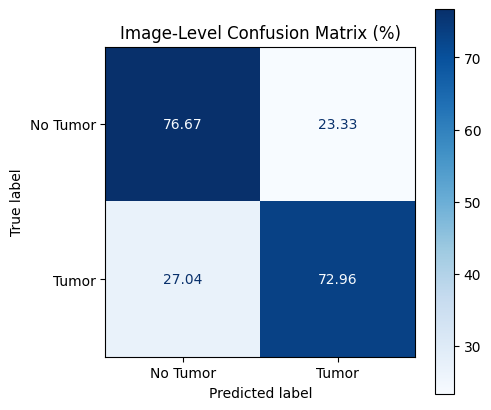

In [ ]:
plot_confusion_matrix_image_level(model_fine_tuned, X_test, y_test)

Visualize patch predictions

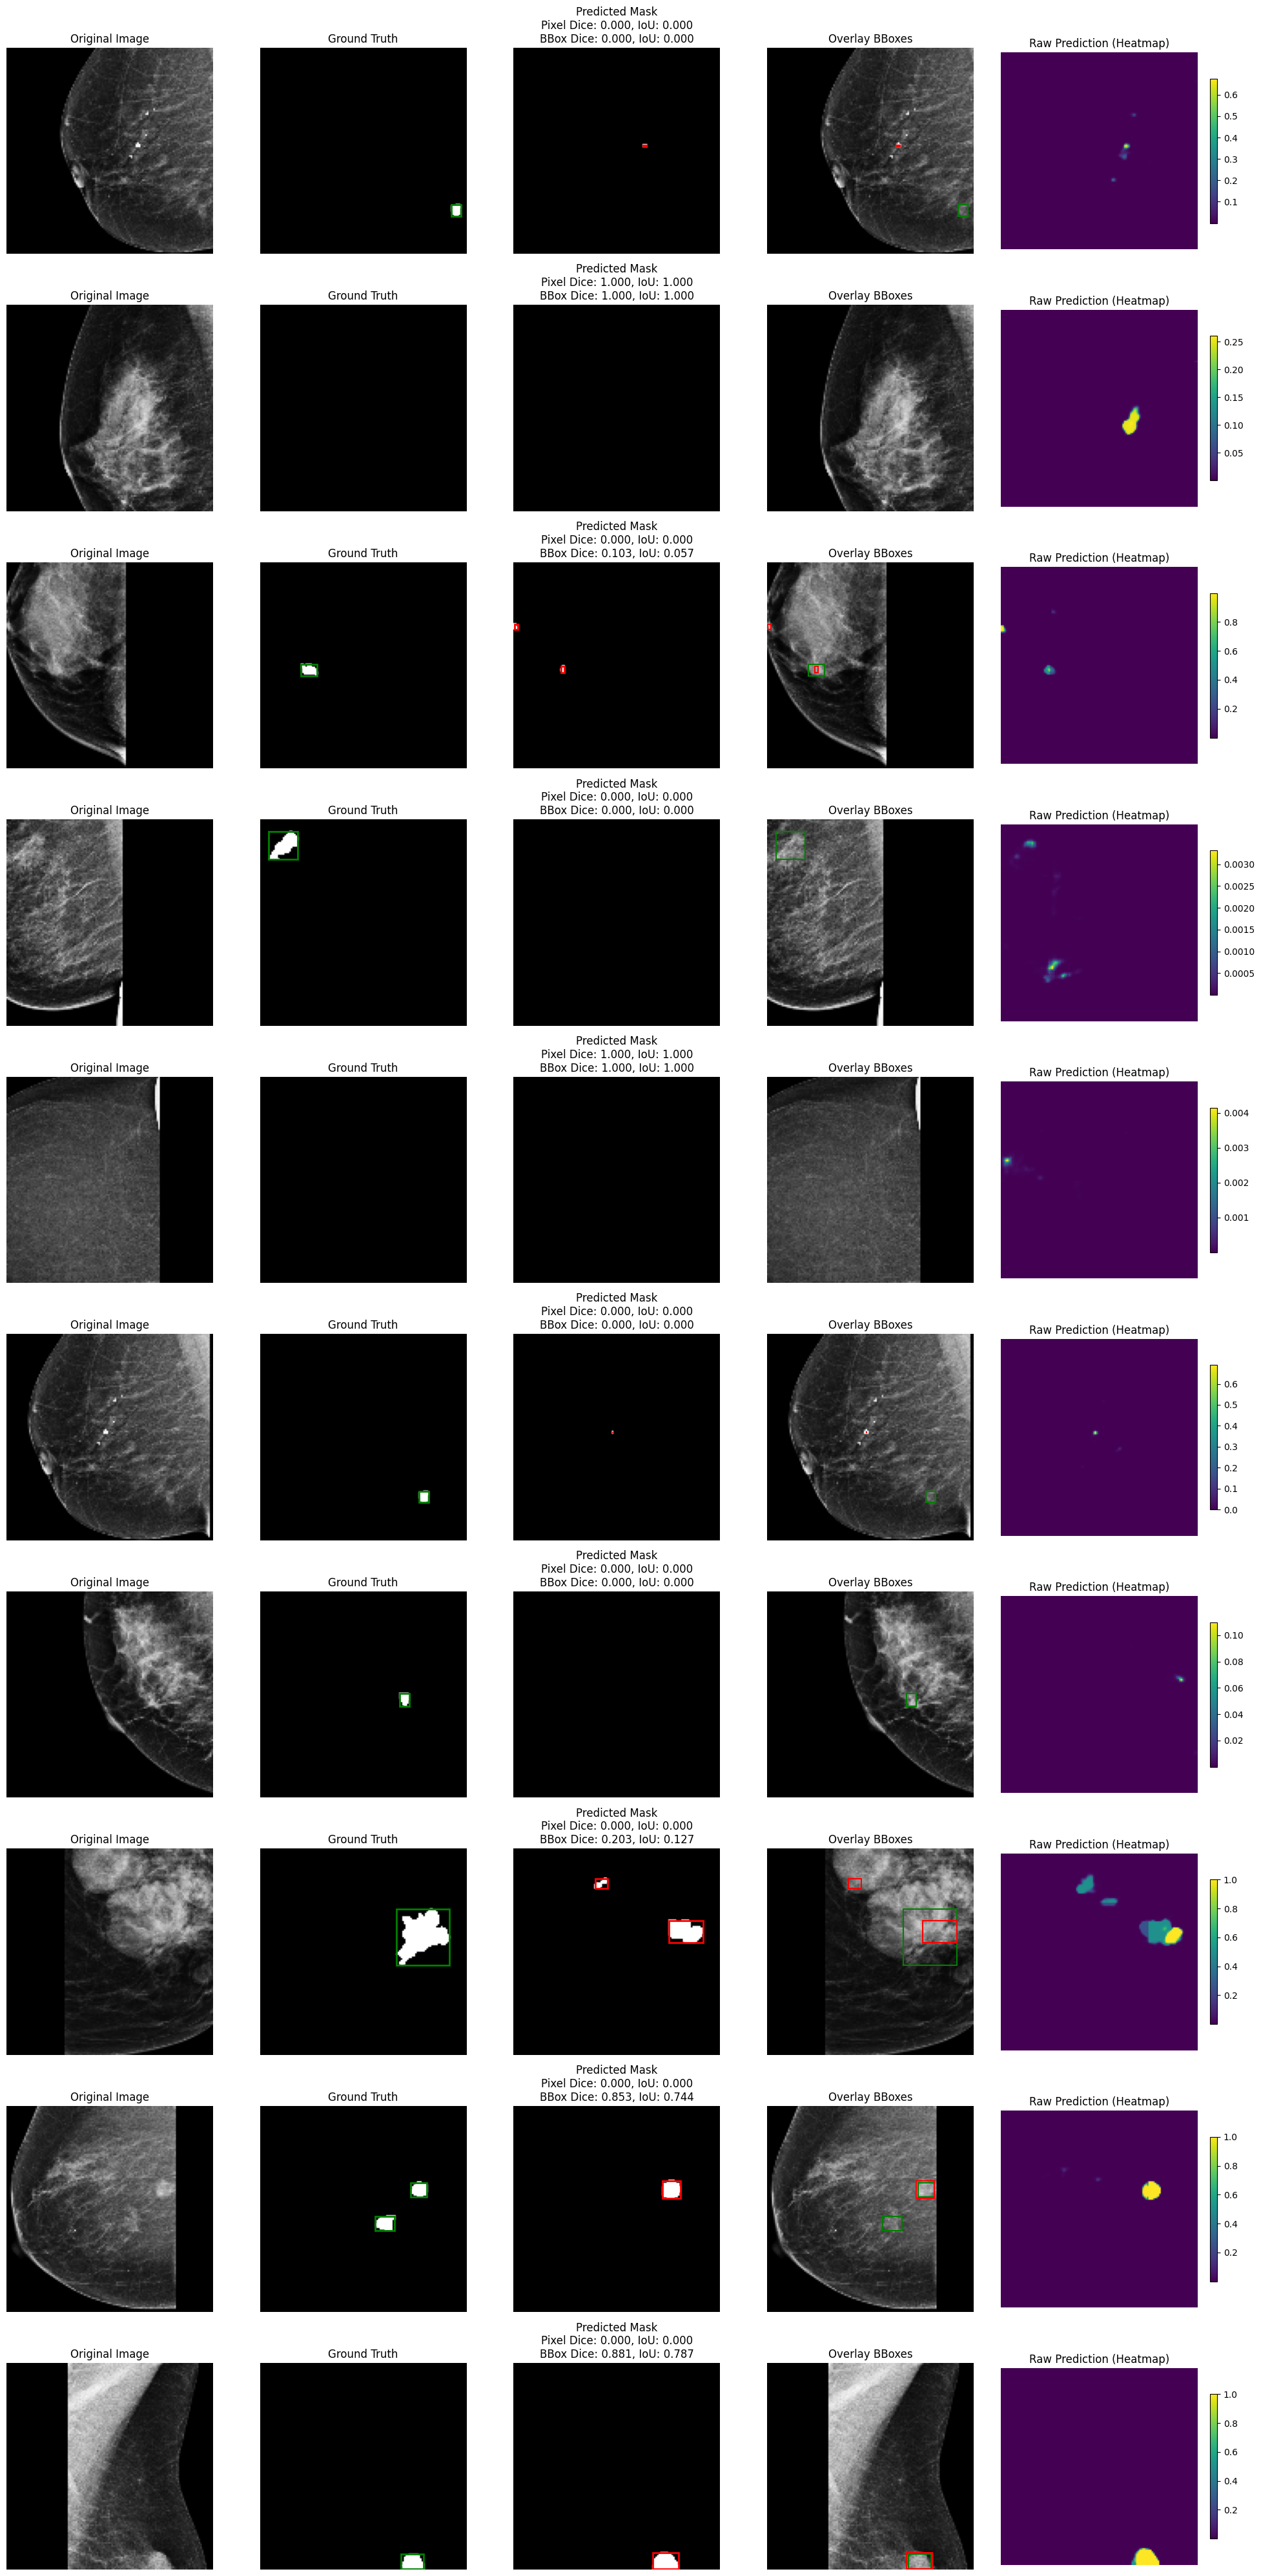

In [ ]:
plot_patchwise_predictions(model_fine_tuned, X_test, y_test, n=10)



---



# **Baseline Model**
**No unfreezing**




In [ ]:
model_depth5 = unet_efficientnet(fine_tune=True, unfreeze_layers=0)
model_depth5.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 128, 128,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 128, 128,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 6,785,444 (25.88 MB)

 Trainable params: 6,742,445 (25.72 MB)

 Non-trainable params: 42,999 (167.97 KB)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model
model_depth5.compile(optimizer=optimizer, loss=combined_loss, metrics=[dice_coefficient])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

early_stopping = EarlyStopping(monitor='val_dice_coefficient', patience=5, mode='max', restore_best_weights=True)

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_depth5.keras',
    monitor='val_dice_coefficient',
    mode='max',
    save_best_only=True,
    verbose=1
)

history_phase1 = model_depth5.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8,
    shuffle=True,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


Epoch 1/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - dice_coefficient: 0.0206 - loss: 1.6720
Epoch 1: val_dice_coefficient improved from -inf to 0.03236, saving model to best_depth5.keras
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 182s 66ms/step - dice_coefficient: 0.0206 - loss: 1.6719 - val_dice_coefficient: 0.0324 - val_loss: 1.3790 - learning_rate: 1.0000e-04
Epoch 2/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - dice_coefficient: 0.0363 - loss: 1.3044
Epoch 2: val_dice_coefficient improved from 0.03236 to 0.06025, saving model to best_depth5.keras
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - dice_coefficient: 0.0363 - loss: 1.3043 - val_dice_coefficient: 0.0602 - val_loss: 1.1722 - learning_rate: 1.0000e-04
Epoch 3/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - dice_coefficient: 0.0719 - loss: 1.1038
Epoch 3: val_dice_coefficient improved from 0.06025 to 0.11922, saving model to best_depth5.keras
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - dice_coefficient: 0.0720 - loss: 1.1038 

Training Curves

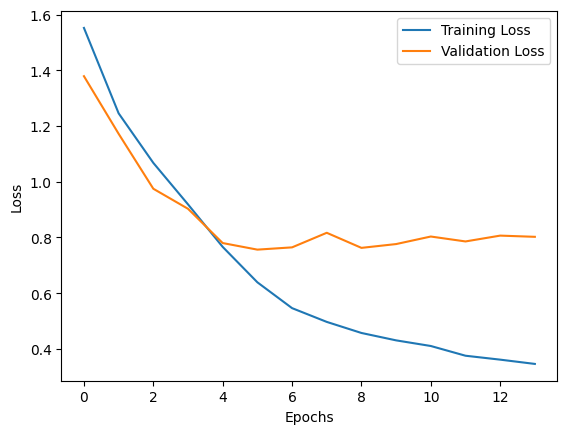

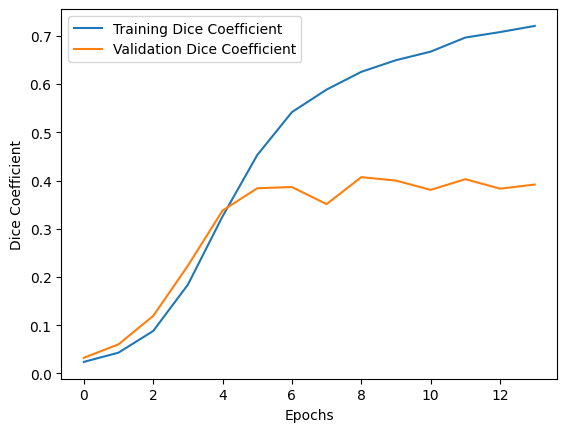

Highest Training Dice Coefficient: 0.7206
Highest Validation Dice Coefficient: 0.4070


In [ ]:
# Plot the training & validation loss values
plt.plot(history_phase1.history['loss'], label='Training Loss')
plt.plot(history_phase1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training & validation Dice Coefficient
plt.plot(history_phase1.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history_phase1.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

# Print the highest Dice coefficient values
highest_dice = max(history_phase1.history['dice_coefficient'])
highest_val_dice = max(history_phase1.history['val_dice_coefficient'])

print(f'Highest Training Dice Coefficient: {highest_dice:.4f}')
print(f'Highest Validation Dice Coefficient: {highest_val_dice:.4f}')

In [ ]:
# Saving model in drive
path_to_best_model = '/content/best_depth5.keras'

drive_path = '/content/drive/MyDrive/NewModels_AllData/tumorpatches6healthy2_Differentaugmentation_unfreeze0/'

os.makedirs(drive_path, exist_ok=True)

shutil.copy(path_to_best_model, drive_path)
print(f'Model checkpoint saved to {drive_path}')


Model checkpoint saved to /content/drive/MyDrive/NewModels_AllData/tumorpatches6healthy2_Differentaugmentation_unfreeze0/


In [22]:
model_path = '/content/drive/MyDrive/NewModels_AllData/tumorpatches6healthy2_Differentaugmentation_unfreeze0/best_depth5.keras'

custom_objects = {'combined_loss': combined_loss, 'dice_coefficient': dice_coefficient}

model_baseline = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

ROC Curve

12/12 ━━━━━━━━━━━━━━━━━━━━ 132s 10s/step


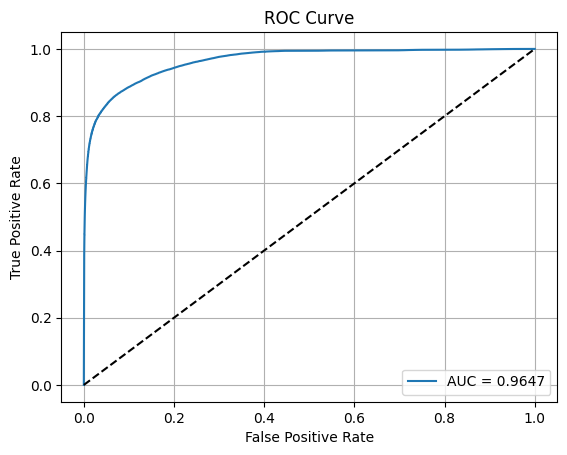

np.float64(0.9647239376218646)

In [23]:
evaluate_roc_auc(model_baseline, X_test, y_test)

Pixel-Level Evaluation Metrics

In [24]:
evaluate_segmentation_model_metrics(model_baseline, X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 94s 8s/step


IoU      Dice  Accuracy  Precision    Recall   ROC AUC
0  0.40681  0.578344  0.993467   0.668319  0.509721  0.964724

Bounding Box-Level Evaluation Metrics

In [26]:
evaluate_bboxes_metrics(model_baseline, X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 102s 8s/step


Average IoU  Average Dice  Precision    Recall
0     0.392695      0.436896      0.575  0.438889

Image-Level Evaluation

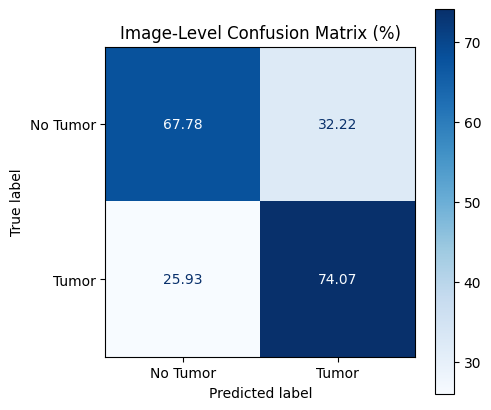

In [ ]:
plot_confusion_matrix_image_level(model_baseline, X_test, y_test)



---



Compare model predictions

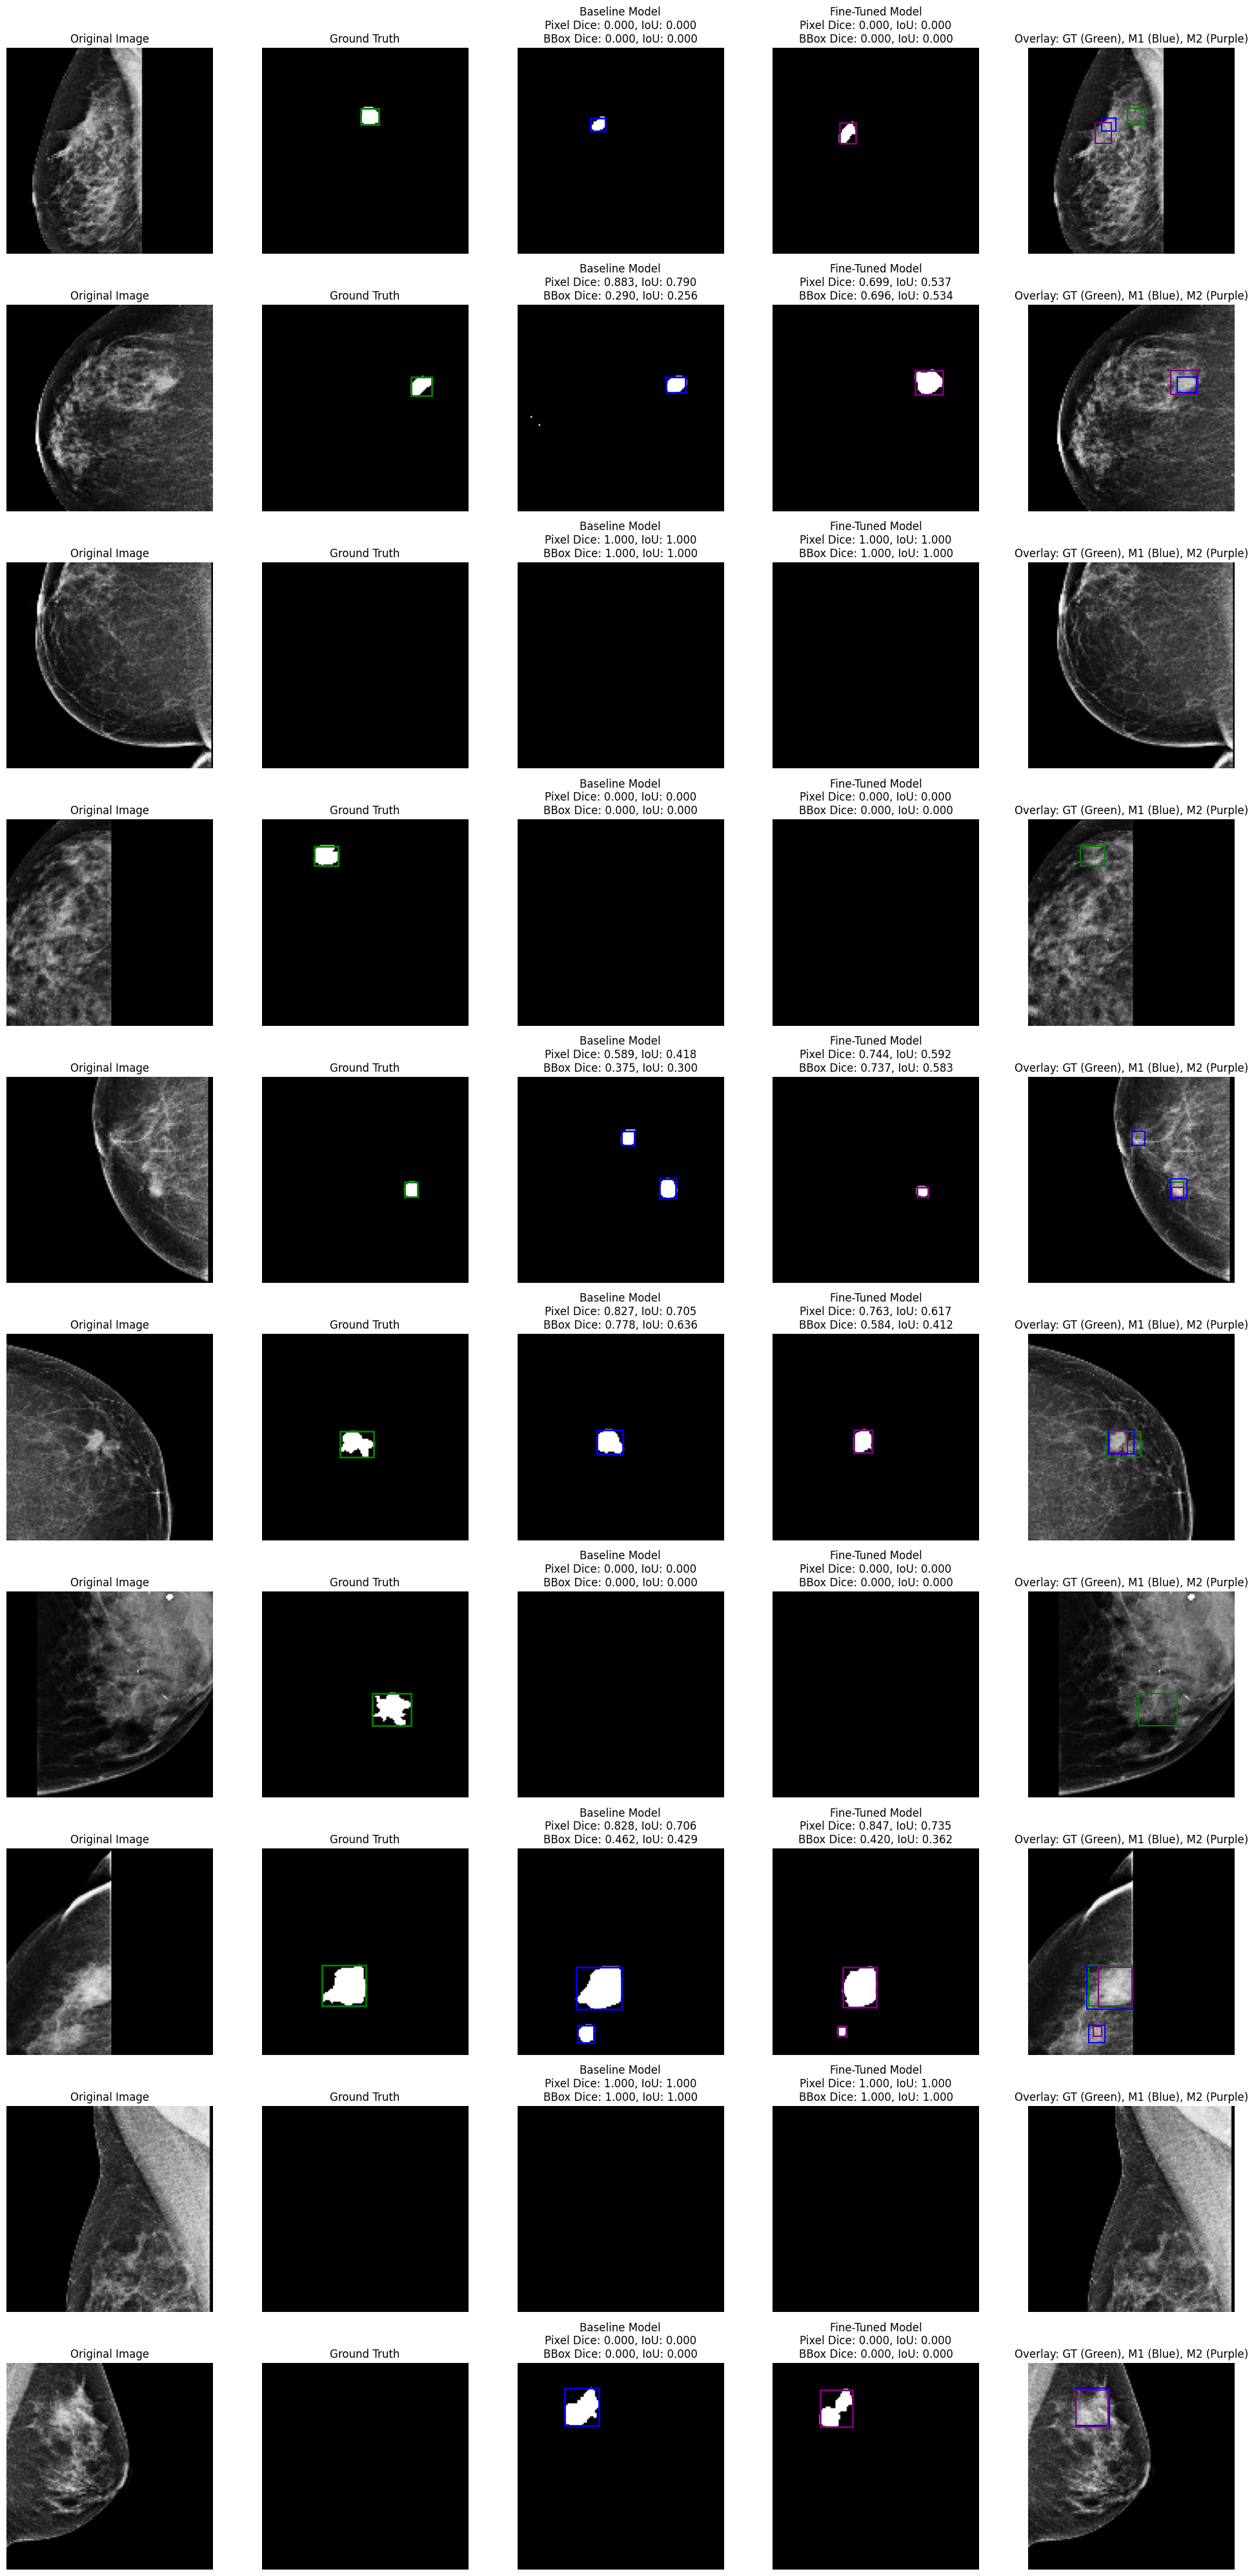

In [30]:
evaluate_and_plot_bboxes_two_models(X_test, y_test, model_baseline, model_fine_tuned, num_images=10)



---



Predictions made on full-size Mammogram Images by fine-tuned model

In [ ]:
# Load all images and masks
healthy_images, healthy_filenames = load_images_from_folder(Images_Healthy_path)
tumor_images, tumor_filenames = load_images_from_folder(Images_Tumor_path)
healthy_masks, _ = load_images_from_folder(Masks_Healthy_path, binarize=True)
tumor_masks, _ = load_images_from_folder(Masks_Tumor_path, binarize=True)

# Create dataset with full images and masks
X_full = np.concatenate((healthy_images, tumor_images), axis=0)
y_full = np.concatenate((healthy_masks, tumor_masks), axis=0)

# Shuffle dataset while maintaining correspondence
X_full, y_full = shuffle(X_full, y_full, random_state=42)


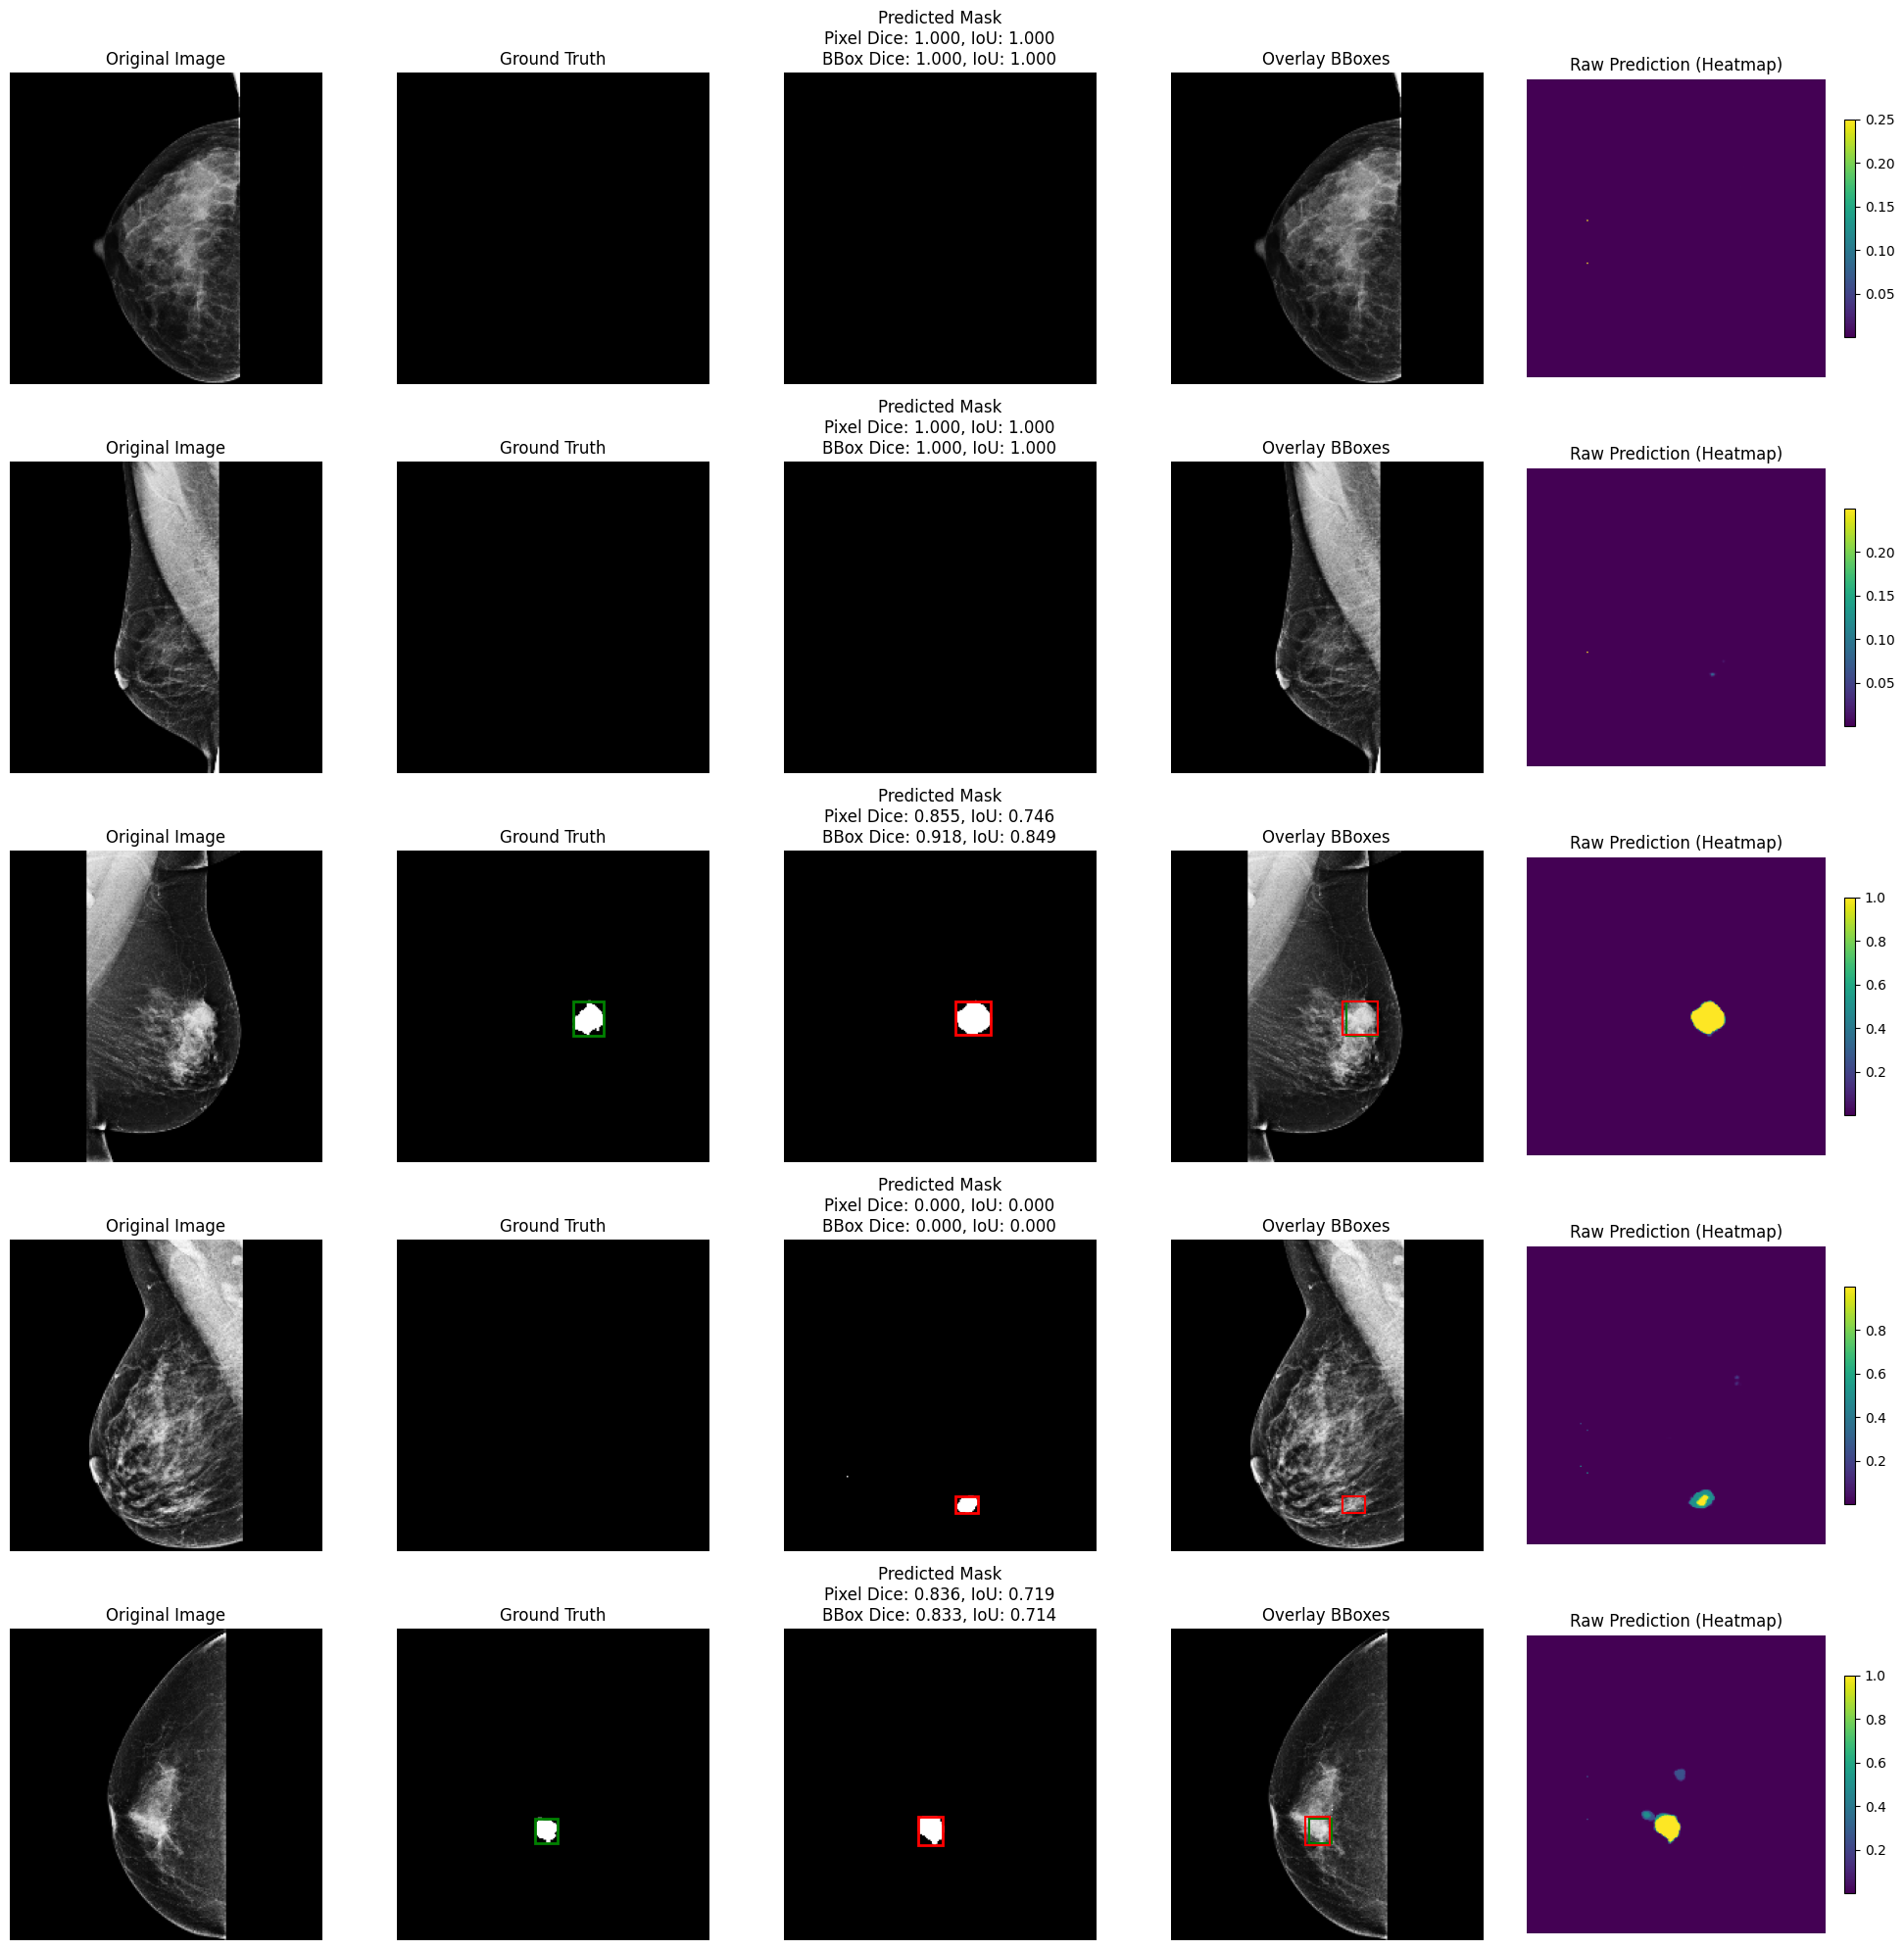

In [ ]:
plot_patchwise_predictions(model_fine_tuned, X_full, y_full, n=5)